#  Web-scraping-bot project - data exploration and analysis

- Data exploration and analysis of a dataset about lifestyle and things to do in Tokyo from a specific website's blog.
- The website's blog articles and related data have been directly scrapped from the web site.
- No data which could lead to this specific website will be shown in this notebook.

In [1]:
# import modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scrappackage.scrap_blog_articles import Website_blog

In [2]:
# magic commands

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# The whole dataset have been scrapped before the creation of this notebook, a week ago.
# Since, some articles could have been published.
# Update the csv file which contains the dataset:
# To avoid scrap all the website's blog articles, update
# the all_articles.csv file with the website's blog articles from the
# first page only. This update could be done every two week as there were
# no more than 25 article publications per month in the past.

# instantiate the Website_blog class.
wb = Website_blog()

# update the csv file:
wb.update_csv_file_with_blog_first_page()

In [265]:
# all_articles.csv relative path
all_articles_csv_file_path = os.path.join("..", "scrappackage", "all_articles.csv")
# read all_articles.csv in a panas dataframe                                                             
df = pd.read_csv(all_articles_csv_file_path)

# 1 - Basic exploration - cardinalities

In [5]:
df.columns

Index(['url', 'title', 'date', 'author', 'categories', 'tags', 'text'], dtype='object')

In [6]:
df.shape

(1609, 7)

In [7]:
df.count()

url           1609
title         1609
date          1520
author        1520
categories    1609
tags          1486
text          1609
dtype: int64

In [8]:
df.nunique()

url           1606
title         1605
date          1270
author         104
categories     176
tags          1385
text          1597
dtype: int64

In [9]:
c_url, c_title, c_date, c_author, c_categories, c_tags, c_text = df.count()
n_url, n_title, n_date, n_author, n_categories, n_tags, n_text = df.nunique()

In [10]:
print(f" - There are {n_url} unique articles in total")
print(f" - {c_title - n_title} duplicated titles")
print(f" - {c_url - c_date} articles have no publication date")
print(f" - More than one articles have been published on {c_date - n_date} publication dates")
print(f" - There are {n_author} authors")
print(f" - {'All' if c_url == c_categories else c_categories} articles have categories")
print(f" - {c_url - c_tags} articles don't have any tag")
print(f" - {c_text - n_text} duplicated texts")

 - There are 1606 unique articles in total
 - 4 duplicated titles
 - 89 articles have no publication date
 - More than one articles have been published on 250 publication dates
 - There are 104 authors
 - All articles have categories
 - 123 articles don't have any tag
 - 12 duplicated texts


In [11]:
# authors anonymation
# add a 'author_anon' column where each unique author name is replaced by a number (-1 if no author)
df['author_anon'] = df['author'].astype('category').cat.codes

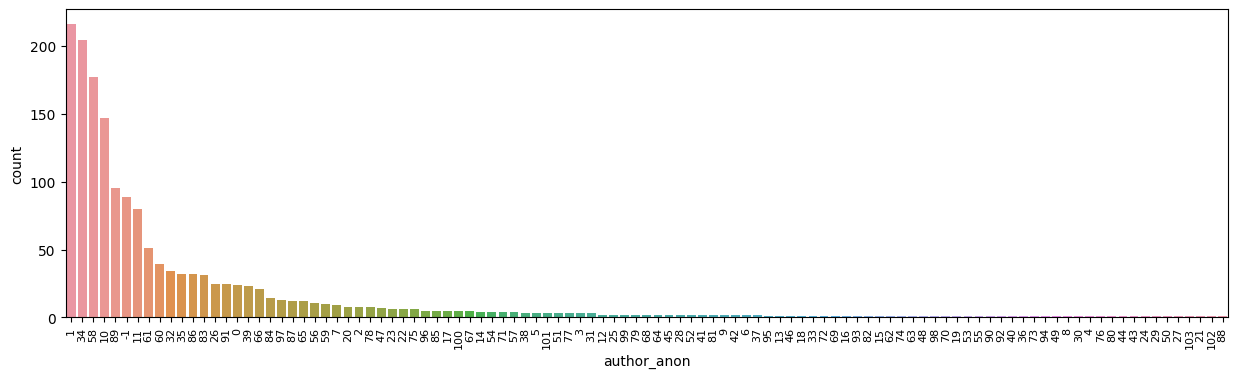

In [12]:
plt.figure(figsize=(15, 4))
sns.countplot(data=df, x='author_anon', order=df['author_anon'].value_counts().index)
plt.xticks(rotation=90, fontsize=8);

In [13]:
# nb articles wrote per author, using bins
df2 = df['author_anon'].value_counts().reset_index().rename(columns={'index': 'author', 'author_anon': 'nb_articles'})
bins = [1, 10, 30, 50, 100, 150, 200, 250]
groups = df2.groupby(['author', pd.cut(df2['nb_articles'], bins)])
articles_per_author_df = groups.size().unstack().agg(sum).reset_index()
articles_per_author_df.columns = ['nb_articles', 'nb_author']
articles_per_author_df

,nb_articles,nb_author
0,"(1, 10]",40
1,"(10, 30]",10
2,"(30, 50]",5
3,"(50, 100]",4
4,"(100, 150]",1
5,"(150, 200]",1
6,"(200, 250]",2


- A minority of authors wrote the majority of the articles

In [14]:
df2['perc'] = round((df2['nb_articles']/df2['nb_articles'].sum())*100, 2)
df2

,author,nb_articles,perc
0,1,216,13.42
1,34,204,12.68
2,58,177,11.00
3,10,147,9.14
4,89,95,5.90
...,...,...,...
100,27,1,0.06
101,103,1,0.06
102,21,1,0.06
103,102,1,0.06


In [15]:
# nb of articles written by top 5 authors
top5 = df2.nlargest(5, "perc", keep='first')[['nb_articles', 'perc']].sum()

print(f"- The top five authors wrote {int(top5['nb_articles'])} over {n_url} articles, which represent more than {int(top5['perc'])}% of the total of the articles.")

- The top five authors wrote 839 over 1606 articles, which represent more than 52% of the total of the articles.


# 2 - Articles' categories and tags

In [16]:
df.categories.head()

0    Outdoors and Nature, Things to do
1                         Things to do
2                             Shopping
3                  Business, Financial
4       Japanese Culture And Tradition
Name: categories, dtype: object

In [17]:
df.tags.head()

0          Festivals, Flowers, Nature, Outdoors, Parks
1    Cars, Cheap tours, Costumes, Fun, Tourists, We...
2                             Fashion, Online shopping
3                                    Business, Finance
4                           Couples, Featured, Shrines
Name: tags, dtype: object

In [18]:
# convert categories into lists of strings
df['categories'] = df['categories'].fillna("")
df['list_categories'] = df['categories'].apply(lambda x: x.split(', '))
df['list_categories'].head()

0    [Outdoors and Nature, Things to do]
1                         [Things to do]
2                             [Shopping]
3                  [Business, Financial]
4       [Japanese Culture And Tradition]
Name: list_categories, dtype: object

In [19]:
# convert tags into lists of strings
df['tags'] = df['tags'].fillna("")
df['list_tags'] = df['tags'].apply(lambda x: x.split(', '))
df['list_tags'].head()

0        [Festivals, Flowers, Nature, Outdoors, Parks]
1    [Cars, Cheap tours, Costumes, Fun, Tourists, W...
2                           [Fashion, Online shopping]
3                                  [Business, Finance]
4                         [Couples, Featured, Shrines]
Name: list_tags, dtype: object

In [20]:
# turn categories into a matrix-like representation
df_categories = pd.get_dummies(df['list_categories'].apply(pd.Series).stack()).groupby(level=0).sum()
df_categories.head()

,Anime And Gaming,Art,Business,Drinking,Eating & Drinking,Editorial,Education,Events,Family,Fashion,...,Shows and Theatre,Sightseeing,Snow Sports,Sporting Activities,Sushi,Sweets,Themeparks and Zoos,Things to do,Tokyo Cafés,Transport
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# turn tags into a matrix-like representation
df_tags = pd.get_dummies(df['list_tags'].apply(pd.Series).stack()).groupby(level=0).sum()
df_tags.head()

,,100 yen shop,47 Ronin,7-Eleven,ATM,Accessories,Accommodation,Africa,Afternoon Tea,Airbnb,...,Yabusame,Yakitori,Yamanashi,Yamanote,Yatai,Yen,Yokocho,Yosakoi,Yukata,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# number of articles per category
articles_per_categories = df_categories.astype(bool).sum(axis=0).sort_values(ascending=False).reset_index()
articles_per_categories.columns = ['categories', 'nb_articles']
articles_per_categories.head()

,categories,nb_articles
0,Things to do,607
1,Events,403
2,Living,179
3,Eating & Drinking,176
4,Shopping,120


In [23]:
# number of articles per tag
articles_per_tags = df_tags.astype(bool).sum(axis=0).sort_values(ascending=False).reset_index()
articles_per_tags.columns = ['tags', 'nb_articles']
articles_per_tags.head()

,tags,nb_articles
0,Featured,530
1,Art,152
2,Tourists,148
3,Festivals,125
4,,123


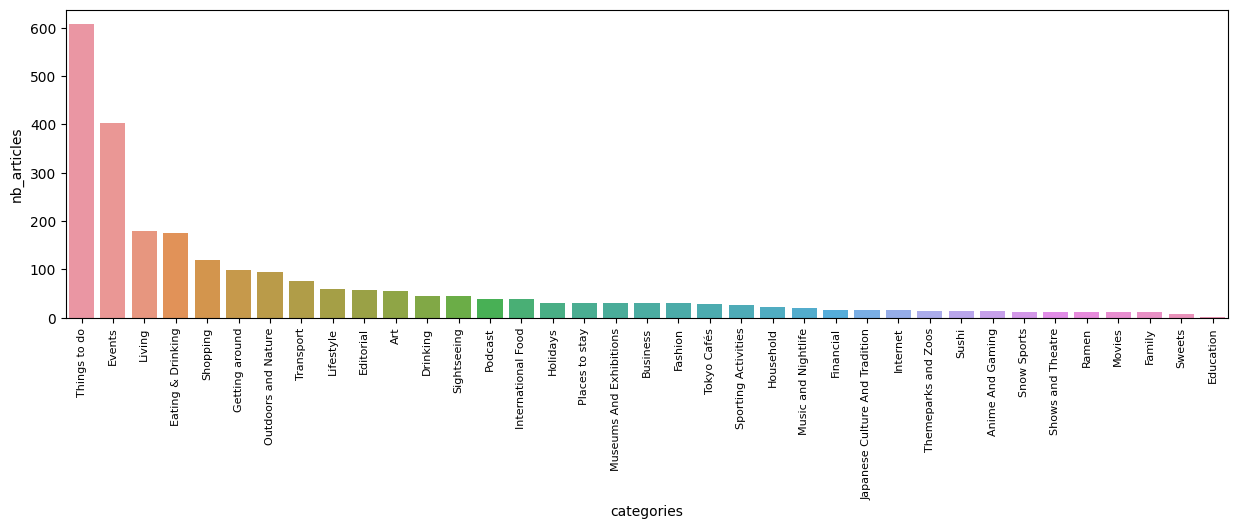

In [24]:
# barplot - nb articles per category
plt.figure(figsize=(15, 4))
sns.barplot(x = 'categories', y = 'nb_articles', data = articles_per_categories)
plt.xticks(rotation=90, fontsize=8);

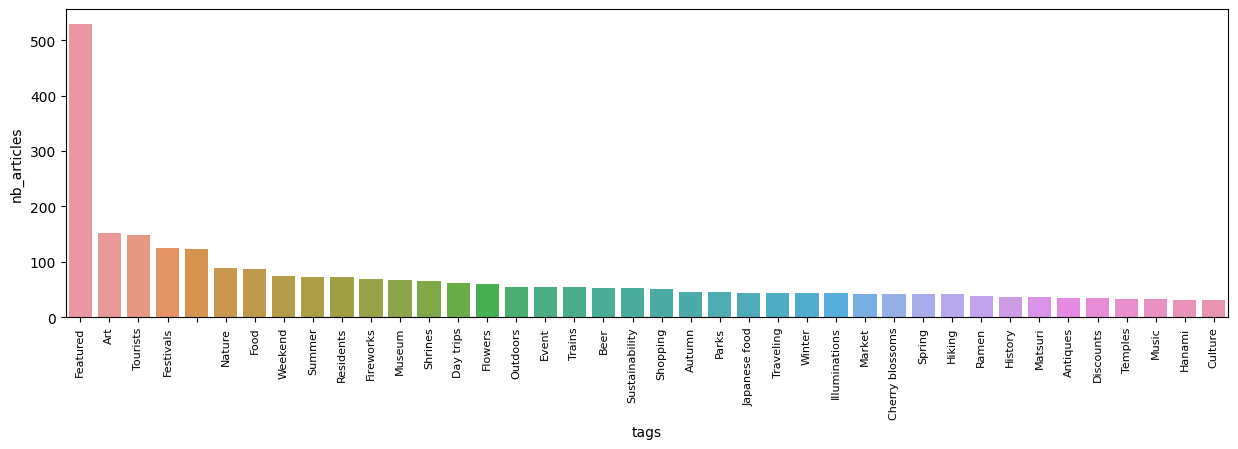

In [25]:
# barplot - nb articles per tag
# as there are more than 800 different tags, limit to the 40 most frequents
plt.figure(figsize=(15, 4))
sns.barplot(x = 'tags', y = 'nb_articles', data = articles_per_tags.head(40))
plt.xticks(rotation=90, fontsize=8);

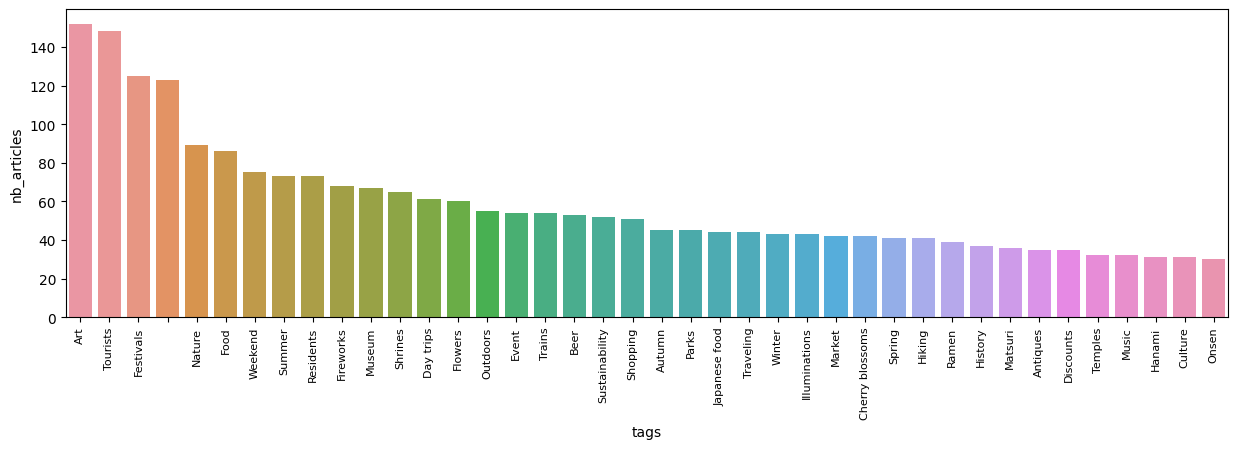

In [26]:
# same barplot, without `Featured` tag
plt.figure(figsize=(15, 4))
sns.barplot(x = 'tags', y = 'nb_articles', data = articles_per_tags[articles_per_tags.tags != 'Featured'].head(40))
plt.xticks(rotation=90, fontsize=8);

# 3 - Article's publication

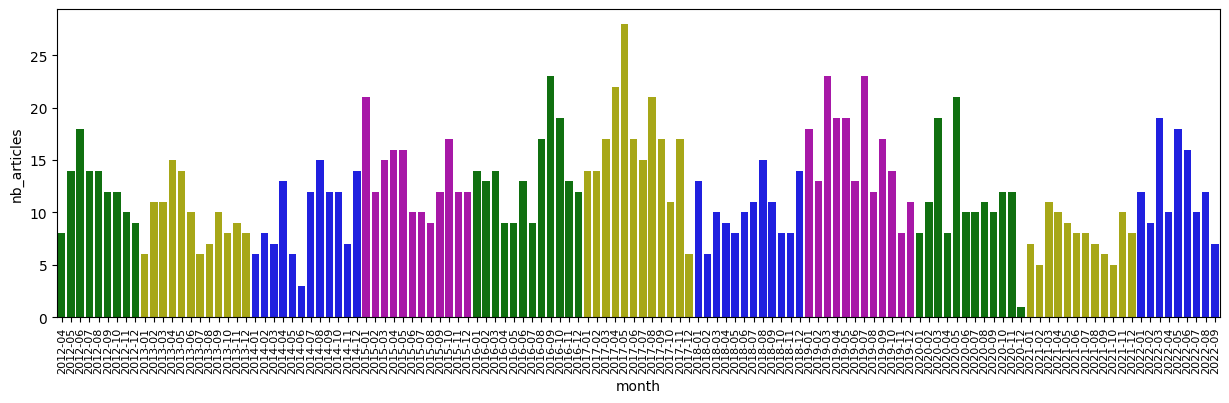

In [266]:
# compute the number of articles published per month
df.index = pd.to_datetime(df['date'])
monthly_published_articles_nb = df.groupby(pd.Grouper(freq='M')).count()['url'].reset_index()
monthly_published_articles_nb['date'] = monthly_published_articles_nb['date'].dt.to_period('M')
monthly_published_articles_nb.columns = ['month', 'nb_articles']

# compute the number of monts per year (a year can be not completed)
nb_month_per_year = list(monthly_published_articles_nb['month'].apply(lambda x: x.year).value_counts().sort_index())

# set a palette with one color per year
colors = ['g', 'y','b', 'm']
pal = []
c = 0
for n in nb_month_per_year:
    pal.append(n * [colors[c]])
    c = 0 if c == len(colors) - 1 else c + 1
pal = sum(pal, [])

# barplot the of the number of articles published per month
nb_years = monthly_published_articles_nb['month'].apply(lambda x: x.year).nunique() # nb of years covered by the dataset
#pal =  # palette set for one color per year

plt.figure(figsize=(15, 4))
sns.barplot(x = 'month', y = 'nb_articles', data = monthly_published_articles_nb, palette=pal);
plt.xticks(rotation=90, fontsize=8);

- This bar plot shows a yearly growth trend of publication articles from 2012 to 2017.
- After 2017, the trend seems quite irregular: less articles in 2018, quite more in 2019, fairly less in 2020 and the trend for 2022 seems to be more articles.

In [267]:
# average number of articles published by month
average_per_month = monthly_published_articles_nb.nb_articles.mean()
print(f"Average number of articles published by month: {round(average_per_month)}")

Average number of articles published by month: 12


In [228]:
# number of published articles per year
yearly_published_articles_nb = df.groupby(pd.Grouper(freq='Y')).count()['url'].reset_index()
yearly_published_articles_nb['date'] = yearly_published_articles_nb['date'].dt.to_period('Y')
yearly_published_articles_nb.columns = ['year', 'nb_articles']
yearly_published_articles_nb

,year,nb_articles
0,2012,111
1,2013,115
2,2014,115
3,2015,162
4,2016,165
5,2017,199
6,2018,123
7,2019,190
8,2020,133
9,2021,94


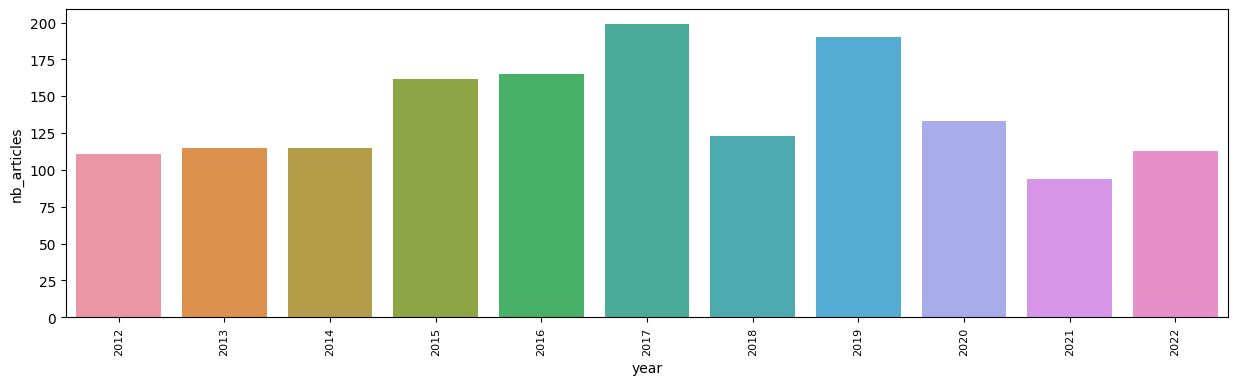

In [230]:
# plot the number of published articles per year
plt.figure(figsize=(15, 4))
sns.barplot(x = 'year', y = 'nb_articles', data = yearly_published_articles_nb);
plt.xticks(rotation=90, fontsize=8);

- This barplot above confirm the growth trend from 2012 to 2017 and the irregular trend after.
- There is significant deop in 2018.
- The drop in 2020 and 2021 can be explained by the Covid-19 outbreak.
- 2022 is already better than 2021

In [221]:
# to be continued

# to to: average articles for each month
# to do: check articles/main authors/year and /month